## Design of spatial loss function for desired similarity decay patterns.

In this tutorial we will demonstrate how to select hyperparameters when constructing the spatial loss function such that the resulting prior will have the desired similarity decay pattern. Empirically, we may want the decay rate of prior correlation to match that of the similarity decay pattern of the observed data, which can be visualized in the previous tutorial.

There are three main components that control the covariance structure of the loss function: 
- Connectivity of the neighborhood graph
- Assumed spatial random process and the autocorrelation parameter $\rho$
- Spatial graph scaling using external information

In [1]:
import itertools
import torch
import pandas as pd
from plotnine import *

from smoother import SpatialWeightMatrix, SpatialLoss

In [2]:
DATA_DIR = "./data/"

# load the example 10x Visium's pixel-level coordinates
# i.e., 'pxl_col_in_fullres' and 'pxl_row_in_fullres'
coords = pd.read_csv(DATA_DIR + "DLPFC_151673_coords.txt", sep = " ", header=0) # num_spots x 2
print(f"Number of spots: {coords.shape[0]}")

Number of spots: 3639


### Graph connectivity
The effect of graph connectivity is indirect. This is because spots that are not connected in the graph can still depend on each other through indirect connections (e.g., neighbor's neighbor). However, the scale of covariance do rely on the graph connectivity. For example, when the graph is constructed using K-nearest neighbors, all connected spot pairs will have roughly the same correlation. Increasing `k` in this case will spread out the dependency while also diluting the influence of the most adjacent spots.

In [3]:
# calculate spatial weight matrix
weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords, k=6)

Number of spots: 3639. Average number of neighbors per spot:  5.85.


### Spatial ramdom process

Smoother offers five different yet related spatial processes: CAR (conditional autoregressive), SAR (simultaneous autoregressive), ICAR, ISAR, and SMA (spatial moving average). Specifically, CAR and SAR are equivalent upon transformation, and ICAR and ISAR are the weights-scaled versions so that the autocorrelation parameter $\rho$ falls in [0, 1]. By adjusting $\rho$, these models can achieve parallel regularization effects. 

Based on numerical considerations, we typically recommend using ICAR with varying $\rho$ (or ISAR with smaller $\rho$) 
to accommodate data with diverse neighborhood structures, for instance, “ICAR ($\rho = 0.99$)” for data with clear anatomy and 
“ICAR ($\rho = 0.9$)” for tumor data. SMA is generally not recommended since the resulting inverse covariance matrix tends to be less sparse, potentially slowing down computation.

In [4]:
# calculate spatial weight matrix
weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords, k=6)

# convert spatial weight into loss
# note that the covariance is improper
spatial_loss = SpatialLoss('icar', weights, rho=0.99)

Number of spots: 3639. Average number of neighbors per spot:  5.85.


To see the effect of model configurations on the resulting covariance structure, we can plot the pairwise correlation distribution as a function of spot distance.

100%|██████████| 51/51 [00:00<00:00, 142.24it/s]


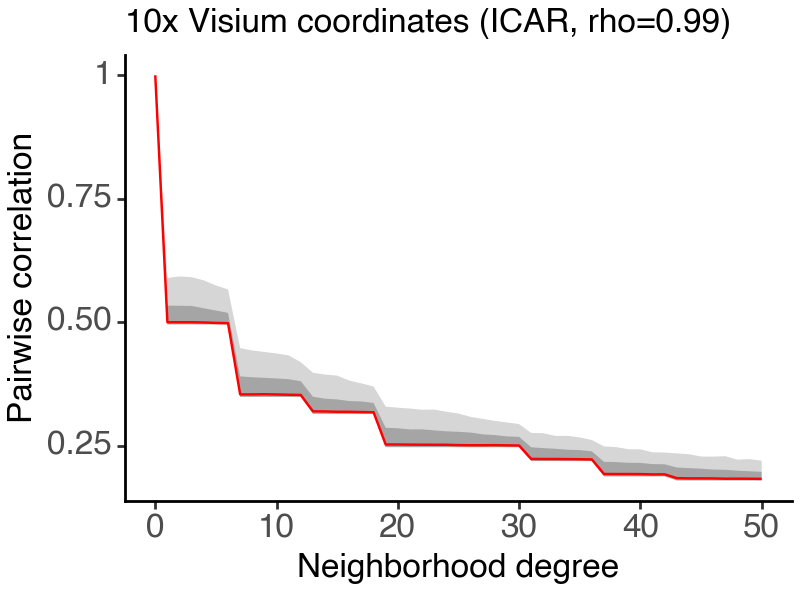

<Figure Size: (400 x 300)>

In [5]:
df_all, df_var = spatial_loss.calc_corr_decay_stats(coords, 0,50, return_var=True)

(
    ggplot(df_all, aes(x = 'k')) + 
    geom_ribbon(aes(x = 'k', ymin = 'Q10', ymax = 'Q90'), alpha = 0.2) + 
    geom_ribbon(aes(x = 'k', ymin = 'Q25', ymax = 'Q75'), alpha = 0.3) + 
    geom_line(aes(x = 'k', y = 'Q50'), color = "red") + 
    labs(
        x = "Neighborhood degree", y = "Pairwise correlation",
        title = "10x Visium coordinates (ICAR, rho=0.99)"
    ) + 
    theme_classic() + 
    theme(figure_size = (4,3),
          text = element_text(size = 12))
)

Now we can check the combined effect of spatial random process and the autocorrelation parameter $\rho$.

In [6]:
df_all = []

for m, rho in itertools.product(['icar', 'isar'], [0, 0.75, 0.9, 0.99]):
    spatial_loss = SpatialLoss(m, weights, rho=rho)
    _df, _ = spatial_loss.calc_corr_decay_stats(coords, 0, 50, return_var=True)
    _df['model'] = m
    _df['rho'] = rho
    df_all.append(_df)

df_all = pd.concat(df_all)

100%|██████████| 51/51 [00:00<00:00, 170.41it/s]
/Users/jysumac/Projects/Smoother/smoother/weights.py:262: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:56.)
100%|██████████| 51/51 [00:00<00:00, 172.56it/s]


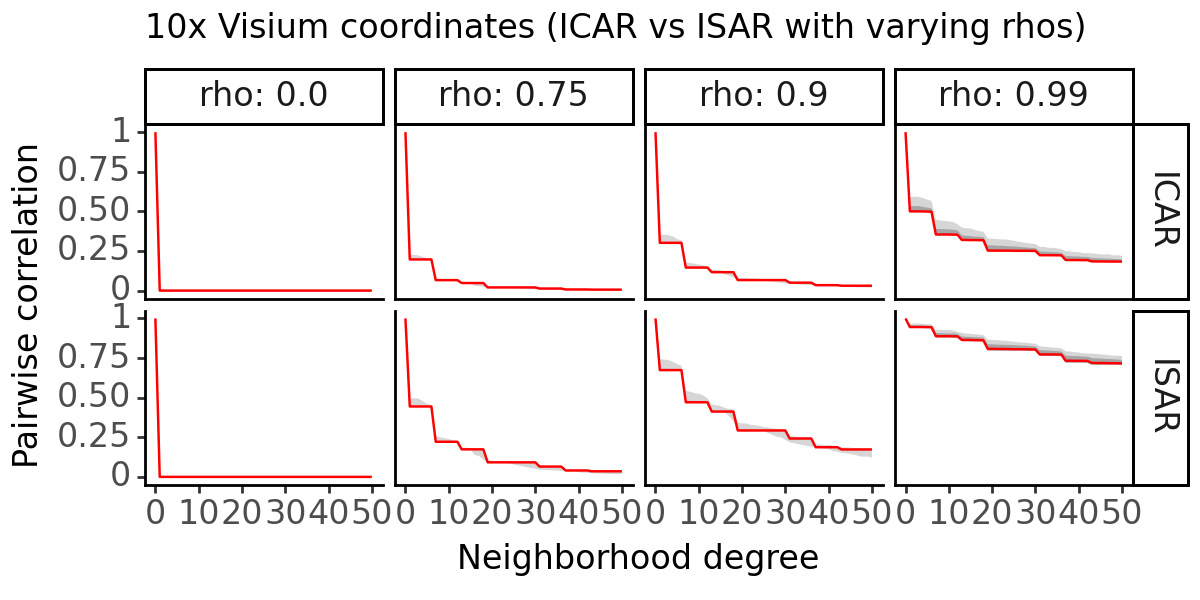

In [7]:
p = (
    ggplot(df_all, aes(x = 'k')) + 
    facet_grid('model~rho', labeller = labeller(rows = str.upper, cols=label_both))+ 
    geom_ribbon(aes(x = 'k', ymin = 'Q10', ymax = 'Q90'), alpha = 0.2) + 
    geom_ribbon(aes(x = 'k', ymin = 'Q25', ymax = 'Q75'), alpha = 0.3) + 
    geom_line(aes(x = 'k', y = 'Q50'), color = "red") + 
    labs(
        x = "Neighborhood degree", y = "Pairwise correlation",
        title = "10x Visium coordinates (ICAR vs ISAR with varying rhos)"
    ) + 
    theme_classic() + 
    theme(figure_size = (6,3),
          text = element_text(size = 12))
)
p.draw()

### Spatial graph scaling

Finally, we demonstrate the effect of graph scaling on the resulting covariance. Scaling is particularly useful when we have external information related to regions and boundaries in the data. By weighting the graph edges by similarity (soft-scaling) or pruning cross-region edges altogether, we can ensure minimal unwanted smoothing, e.g. between tumor cells and surrounding stromal cells. 

Here we show an example of soft-scaling using expression similarity.

In [8]:
weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords, k=6)

# the unscaled spatial loss
sp_loss_raw = SpatialLoss('icar', weights, rho=0.99)
df_all_raw, _ = sp_loss_raw.calc_corr_decay_stats(coords, 0, 50, return_var=True)
df_all_raw['scale'] = 'Raw'

Number of spots: 3639. Average number of neighbors per spot:  5.85.


100%|██████████| 51/51 [00:00<00:00, 141.46it/s]


In [9]:
# read in log_count matrices
# spatial log-normalized count matrix, num_gene x num_spot
y_df = pd.read_csv(DATA_DIR + "DLPFC_151673_marker_log_exp.txt", sep = " ", header=0)
y = torch.tensor(y_df.values).float()

# calculate spatial weight matrix
weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords, k=6)

# scale the spatial weight matrix by transcriptional similarity
weights.scale_by_expr(y)

# convert spatial weight into loss
# note that the covariance is improper
sp_loss_scaled = SpatialLoss('icar', weights, rho=0.99)
df_all_scaled, _ = sp_loss_scaled.calc_corr_decay_stats(coords, 0, 50, return_var=True)
df_all_scaled['scale'] = 'Soft-scaled by expression'

Number of spots: 3639. Average number of neighbors per spot:  5.85.
Number of spots: 3639. Average number of neighbors per spot:  5.86.


100%|██████████| 51/51 [00:00<00:00, 137.35it/s]


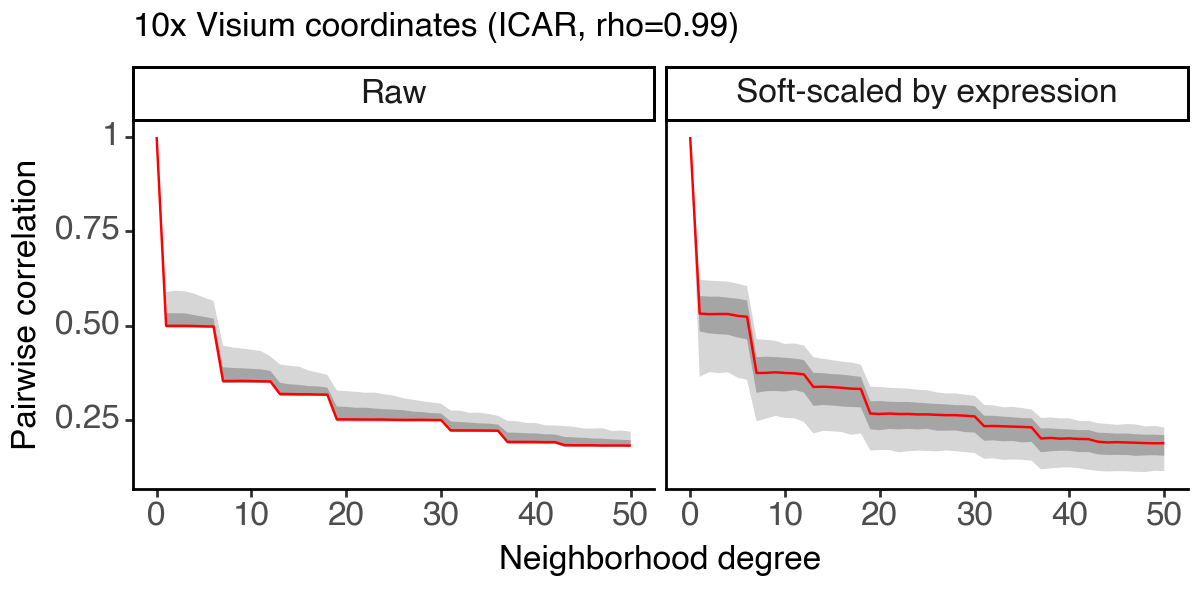

<Figure Size: (600 x 300)>

In [10]:
df_all = pd.concat([df_all_raw, df_all_scaled])

(
    ggplot(df_all, aes(x = 'k')) + 
    facet_wrap('~scale', nrow = 1) +
    geom_ribbon(aes(x = 'k', ymin = 'Q10', ymax = 'Q90'), alpha = 0.2) + 
    geom_ribbon(aes(x = 'k', ymin = 'Q25', ymax = 'Q75'), alpha = 0.3) + 
    geom_line(aes(x = 'k', y = 'Q50'), color = "red") + 
    labs(
        x = "Neighborhood degree", y = "Pairwise correlation",
        title = "10x Visium coordinates (ICAR, rho=0.99)"
    ) + 
    theme_classic() + 
    theme(figure_size = (6,3),
          text = element_text(size = 12))
)